# Quantum Neural Networks

Neural networks and all its specialized architectures such as ConvNets, LSTMs, ResNets, and GANs are part of a broader idea called **differental computing.** Differentible computing is computation carried out using functions with known gradients. These functions have adjustable parameters, and the gradients tell us how to adjust those parameters so that the function performs in a desired manner. 

> A quantum neural network is any quantum circuit with trainable continuous parameters.

In NISQ-era, quantum computing is increasingly being viewed as a form of differential computing. After all, quantum computing is just linear algebra in higher dimensional space.

<center>
<figure>
    <img src="./images/qnn_example_circuit.webp", width="50%">
    <figcaption>A quantum circuit whose gates have free parameters. These can be trained the same way as a deep neural network.</figcaption>
</figure>
</center>

These circuits also go by the name **variational quantum circuits** as they were initially proposed for chemistry problems as **variational quantum eigensolvers (VQEs).**

**PennyLane**, a leading software package for quantum machine learning, provides two key features:
- Automatic differentiation for quantum circuits
- QNode abstraction for building hybrid classical-quantum circuits

### Comparison of some available quantum software libraries

<center>
<figure>
    <img src="./images/qnn_tools.webp", width="50%">
    <figcaption>Comparison of some available quantum software libraries.</figcaption>
</figure>
</center>

## Example Circuit: Training a quantum circuit with PennyLane and PyTorch

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

import qutip as qt
import imageio

### Defining the quantum circuit

One with Expectation value as output for training, and the other with the quantum state as output foor simulation.

In [3]:
dev = qml.device("lightning.qubit", wires=1)

# Trainable quantum circuit
@qml.qnode(dev, interface="torch")
def circuit(phi, theta):
    qml.RX(theta, wires=0)
    qml.RZ(phi, wires=0)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface="torch")
def circuit_states(phi, theta):
    qml.RX(theta, wires=0)
    qml.RZ(phi, wires=0)
    return qml.state()

### Visualizing the Circuit

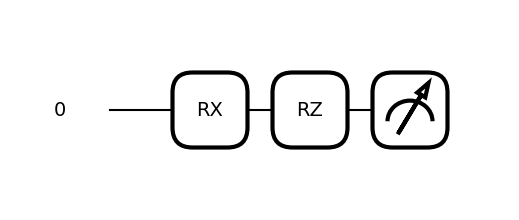

In [4]:
params = np.random.random(2)
# print(qml.draw(circuit)(*params))
qml.draw_mpl(circuit)(*params)
plt.show()

### Define the cost function to minimize

The target defined in the cost function itself, where the polarity changes after every 100 steps.

In [5]:
def cost(phi, theta, step):
    target = -(-1) ** (step//100)
    return torch.abs(circuit(phi, theta)-target)**2

### Training

In [6]:
phi = Variable(torch.tensor(1.), requires_grad=True)
theta = Variable(torch.tensor(0.5), requires_grad=True)
opt = torch.optim.Adam([phi, theta], lr=0.1)

states = []

for i in range(400):
    states.append(circuit_states(phi, theta))
    opt.zero_grad()
    loss = cost(phi, theta, i)
    loss.backward()
    opt.step()
states.append(circuit_states(phi, theta))

### Making and saving bloch diagrams

In [7]:
b = qt.Bloch()
dst = "images/bloch/"
paths = []

for i in range(len(states)):
    b.clear()
    s = qt.Qobj(states[i].detach().numpy())
    b.add_states(s)
    paths.append(f"{dst}{i}.png")
    b.save(dst + f"{i}")

### Merging all the bloch images into a GIF

In [9]:
images = []
for filename in paths:
    images.append(imageio.imread(filename))
imageio.mimsave('images/bloch.gif', images)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6124\3862700166.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


### Output GIF

![bloch](images/bloch.gif)

# QNN for Fashion MNIST

## Resources

- [Medium Article - Nathan Killoran, Josh Izaac](https://medium.com/xanaduai/training-quantum-neural-networks-with-pennylane-pytorch-and-tensorflow-c669108118cc)
- [Medium - Hybrid QNN for reduced MNIST data](https://towardsdatascience.com/hybrid-quantum-neural-network-for-reduced-mnist-data-840897ad08a)
- [Q-munity - Intermediate QNN](https://www.qmunity.tech/tutorials/quantum-neural-networks)
- [QNN - A Practical Approach - Piotr Gawron](https://conference.ippp.dur.ac.uk/event/929/attachments/3968/4559/piotr_gawron_quantum_neural_networks.pdf)
- [QNN Dropout - PennyLane Tutorial](https://pennylane.ai/qml/demos/tutorial_quantum_dropout/)